<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/master/notebooks/fpn_builder_random_rectangles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization==0.3.0.dev6
! pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git

     |████████████████████████████████| 163kB 4.9MB/s 
     |████████████████████████████████| 296kB 9.2MB/s 
  Cloning https://github.com/kmkolasinski/keras_detection.git to /tmp/pip-req-build-hmhuq00b
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-hmhuq00b
     |████████████████████████████████| 17.3MB 194kB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 952kB 42.6MB/s 
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=74910 sha256=ca1188bcc3e886ee59a1698d09c867918aa4b85cacfcacca684793575cc1dcb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ict7mndi/wheels/9c/23/23/2d3299a84b3beda7addbe5f17af1aa74b0e15fd87214803132
Successfully built keras-detection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have 

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras_detection.datasets.datasets_ops as datasets_ops
import keras_detection.datasets.random_rectangles as random_rects
from keras_detection import ImageData

In [0]:
keras = tf.keras

In [0]:
# Run this if you see tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
_logger.propagate = False
if len(_logger.handlers) > 1:
  _logger.handlers.pop(0)

Random rectangles detection dataset

In [5]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(min_max_num_boxes=(5, 30), min_max_height=(0.05, 0.2), alpha=0.2)
)
dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [0]:
# Benchmark dataset sampling
# %timeit next(iter(dataset))

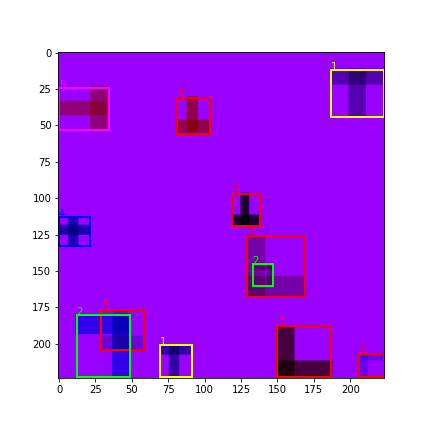

In [7]:
image_data = ImageData.from_dict(next(iter(dataset)))
image_data.draw_boxes()

# Build dataset (batched) and FPN detection model 

In [0]:
import keras_detection.datasets.datasets_ops as datasets_ops

def aug_fn(image_data: ImageData) -> ImageData:
    image = tf.cast(image_data.features.image, tf.float32)
    # example augmentation 
    image_shape = tf.shape(image)
    image = image + tf.random.uniform(minval=-10.0, maxval=10.0, shape=image_shape)
    return image_data.replace_image(image)


image_dim = 224
batch_size = 32
shuffle_buffer_size = 1 # we don't have to shuffle random rectangles dataset
num_classes = 9 # random rectangles have 9 classes
num_parallel_calls = tf.data.experimental.AUTOTUNE

In [0]:
train_dataset = datasets_ops.prepare_dataset(
    dataset,
    model_image_size=(image_dim, image_dim),
    augmentation_fn=aug_fn,
    num_epochs=-1,
    batch_size=batch_size ,
    shuffle_buffer_size=shuffle_buffer_size,
    prefetch_buffer_size=4,
    num_parallel_calls=num_parallel_calls
)

In [0]:
# %timeit next(iter(train_dataset))

# Build model builder 

In [0]:
from keras_detection import FPNBuilder
from keras_detection.tasks import standard_tasks
from keras_detection.backbones import resnet
from keras_detection.utils import plotting


backbone = resnet.ResNetBackbone(
    input_shape=(image_dim, image_dim, 3),
    units_per_block=(1, 1),
    num_last_blocks=1, # number of feature pyramids, setting single feature map
)

# Setting task quantizable to False will make that only the resnet backbone will be quantized
# other layers (tasks (heads) layers) will be trained in full precision.  

tasks = [
    # predicts objectnes score for each anchor
    standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin", quantizable=False),
    # predicts [height, with, y_center, x_center] location of the box
    standard_tasks.get_box_shape_task("box_shape", quantizable=False),
    # predicts [num_classes] for each anchor (focal loss is not supported yet)
    standard_tasks.get_multiclass_task(num_classes, fl_gamma=0.0, label_smoothing=0, activation='softmax', quantizable=False),
]

builder = FPNBuilder(backbone=backbone, tasks=tasks)

In [12]:
model = builder.build()

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model (Model)                   [(None, 56, 56, 64), 317650      tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model[1][1]                      
____________________________________________________________________________________________

In [0]:
# check resnet backbone
# model.layers[2].summary()

## Prepare labels (targets) for objectness, box shape regression and classes

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [16]:
prepared_train_dataset

<MapDataset shapes: ({image: (32, 224, 224, 3)}, {fm28x28/objectness: (32, 28, 28, 2), fm28x28/box_shape: (32, 28, 28, 5), fm28x28/classes: (32, 28, 28, 11)}), types: ({image: tf.float32}, {fm28x28/objectness: tf.float32, fm28x28/box_shape: tf.float32, fm28x28/classes: tf.float32})>

In [0]:
features, labels = next(iter(prepared_train_dataset))

Validating targets: objectness, box prediction and class predictions heads

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


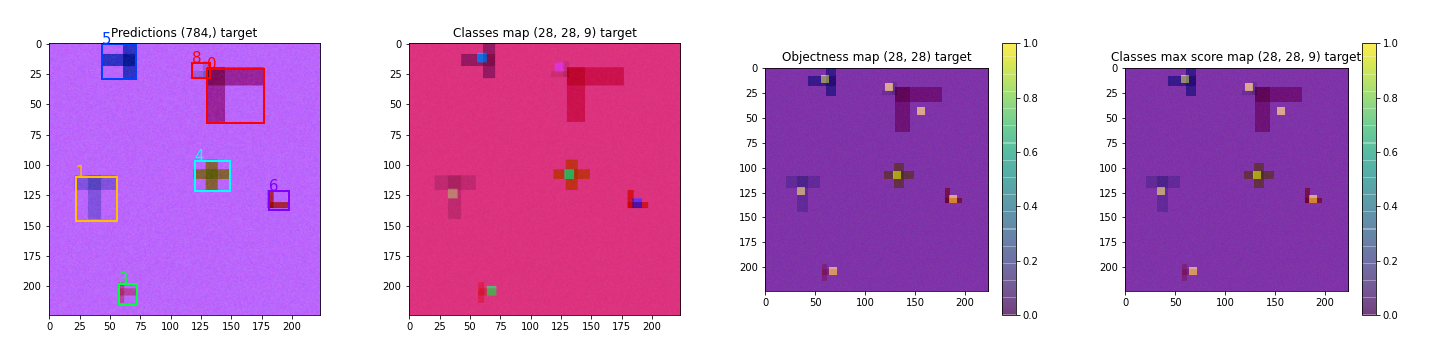

In [18]:
fm = "fm28x28"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 0
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

# Train standard Keras model and export to TFLite 

In [0]:
import keras_detection.models.utils as kd_utils

l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
379/500 [=====================>........] - ETA: 19s - loss: 0.6169 - fm28x28/objectness_loss: 0.0968 - fm28x28/box_shape_loss: 0.0299 - fm28x28/classes_loss: 0.2006 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.1409 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9328 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.7724 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0996 - fm28x28/classes_MulticlassAccuracyMetric: 0.6715

/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/random_rectangles.py:226: RuntimeWarning: invalid value encountered in true_divide
  bg_color = bg_color / bg_color.max()


500/500 [==============================] - 81s 162ms/step - loss: 0.5316 - fm28x28/objectness_loss: 0.0822 - fm28x28/box_shape_loss: 0.0267 - fm28x28/classes_loss: 0.1619 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.1522 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9432 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.8083 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0923 - fm28x28/classes_MulticlassAccuracyMetric: 0.7285
Epoch 2/5
500/500 [==============================] - 82s 164ms/step - loss: 0.2113 - fm28x28/objectness_loss: 0.0268 - fm28x28/box_shape_loss: 0.0136 - fm28x28/classes_loss: 0.0271 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2014 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9859 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9449 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0655 - fm28x28/classes_MulticlassAccuracyMetric: 0.9479
Epoch 3/5
500/500 [==============================] - 83s 165ms/step - loss: 0.1797 - fm28x28/objectn

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 82s 164ms/step - loss: 0.1275 - fm28x28/objectness_loss: 0.0160 - fm28x28/box_shape_loss: 0.0079 - fm28x28/classes_loss: 0.0129 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2276 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9959 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9692 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0594 - fm28x28/classes_MulticlassAccuracyMetric: 0.9823
Epoch 2/5
370/500 [=====================>........] - ETA: 21s - loss: 0.1222 - fm28x28/objectness_loss: 0.0155 - fm28x28/box_shape_loss: 0.0075 - fm28x28/classes_loss: 0.0124 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2282 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9960 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9700 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0593 - fm28x28/classes_MulticlassAccuracyMetric: 0.9829

/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/random_rectangles.py:226: RuntimeWarning: invalid value encountered in true_divide
  bg_color = bg_color / bg_color.max()


500/500 [==============================] - 83s 165ms/step - loss: 0.1219 - fm28x28/objectness_loss: 0.0156 - fm28x28/box_shape_loss: 0.0075 - fm28x28/classes_loss: 0.0124 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2281 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9960 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9699 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0592 - fm28x28/classes_MulticlassAccuracyMetric: 0.9832
Epoch 3/5
500/500 [==============================] - 83s 165ms/step - loss: 0.1179 - fm28x28/objectness_loss: 0.0152 - fm28x28/box_shape_loss: 0.0072 - fm28x28/classes_loss: 0.0119 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2291 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9965 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9708 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0592 - fm28x28/classes_MulticlassAccuracyMetric: 0.9842
Epoch 4/5
500/500 [==============================] - 84s 169ms/step - loss: 0.1158 - fm28x28/objectn

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 84s 167ms/step - loss: 0.1057 - fm28x28/objectness_loss: 0.0142 - fm28x28/box_shape_loss: 0.0063 - fm28x28/classes_loss: 0.0105 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2327 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9973 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9729 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0581 - fm28x28/classes_MulticlassAccuracyMetric: 0.9873
Epoch 2/5
110/500 [=====>........................] - ETA: 1:05 - loss: 0.1043 - fm28x28/objectness_loss: 0.0142 - fm28x28/box_shape_loss: 0.0062 - fm28x28/classes_loss: 0.0105 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2350 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9972 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9730 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0574 - fm28x28/classes_MulticlassAccuracyMetric: 0.9878

/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/random_rectangles.py:226: RuntimeWarning: invalid value encountered in true_divide
  bg_color = bg_color / bg_color.max()


500/500 [==============================] - 84s 167ms/step - loss: 0.1031 - fm28x28/objectness_loss: 0.0139 - fm28x28/box_shape_loss: 0.0061 - fm28x28/classes_loss: 0.0102 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2333 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9974 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9733 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0574 - fm28x28/classes_MulticlassAccuracyMetric: 0.9877
Epoch 3/5
500/500 [==============================] - 83s 167ms/step - loss: 0.1030 - fm28x28/objectness_loss: 0.0140 - fm28x28/box_shape_loss: 0.0061 - fm28x28/classes_loss: 0.0103 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2333 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9974 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9732 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0577 - fm28x28/classes_MulticlassAccuracyMetric: 0.9874
Epoch 4/5
500/500 [==============================] - 84s 168ms/step - loss: 0.1026 - fm28x28/objectn

In [0]:
!mkdir --parents models
model.save_weights("models/non-quantized-model.h5")

In [0]:
model.load_weights("models/non-quantized-model.h5")

## Test trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


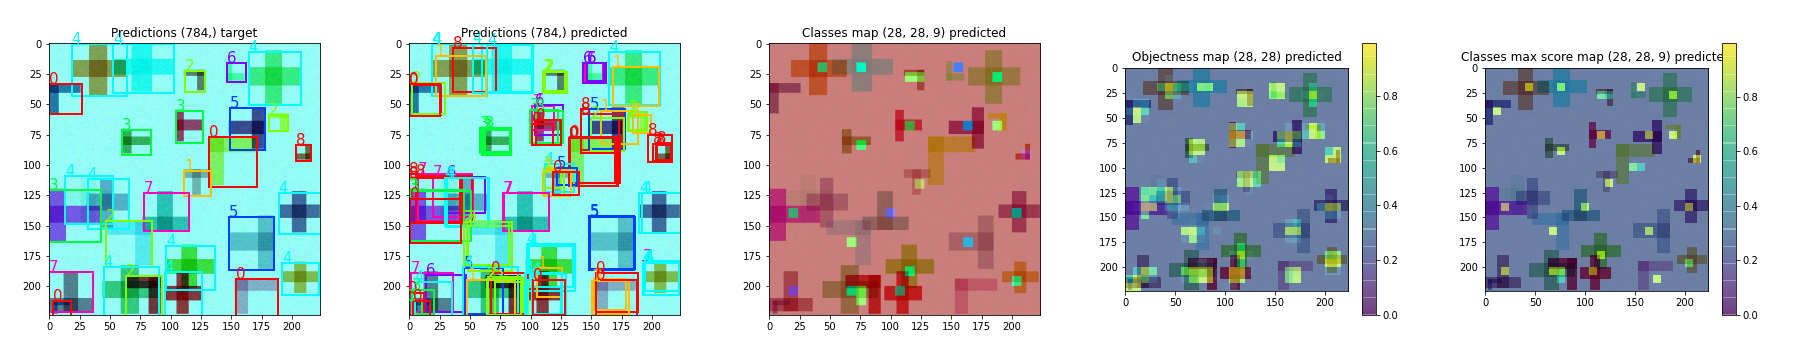

In [24]:
def draw_predictions(model, features, labels, idx = 0, fm = "fm28x28", score_threshold = 0.5):
  
  predictions = model.predict(features)
  predictions = builder.predictions_to_dict(predictions, postprocess=True)

  
  targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
  targets = builder.predictions_to_dict(targets, postprocess=True)

  target=dict(
      objectness=targets[f'{fm}/objectness'][idx],
      boxes_shape_map=targets[f'{fm}/box_shape'][idx],
      classes_map=targets[f'{fm}/classes'][idx],
  )

  predicted=dict(
      objectness=predictions[f'{fm}/objectness'][idx],
      boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
      classes_map=predictions[f'{fm}/classes'][idx],
  )

  render = plotting.draw_compares(    
      target=target,
      predicted=predicted,
      draw_fns=[
          plotting.draw_boxes, 
          plotting.draw_classes_map,
          plotting.draw_objectness_map,
          plotting.draw_classes_max_score_map,
      ],
      image=features['image'][idx] / 255,
      score_threshold=score_threshold,
  )
  return render


features, labels = next(iter(prepared_train_dataset))
draw_predictions(model, features, labels)

## Export model to tflite

In [25]:
# creates two versions of the model:  
#  - models/non-quantized-model.tflite
#  - models/non-quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(    
    model, 
    save_path="models/non-quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between (per image data)
    num_dataset_samples = 64, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=True # Use represenetative dataset to create integer quantized model
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity:0", shape=(1, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity:0", shape=(1, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes/Identity:0", shape=(1, 784, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                      

100%|██████████| 16/16 [00:02<00:00,  7.84it/s]

INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001357 
	RMSE    =  0.006444 
	Keras   = N(μ=  0.077025, σ=  0.236054)
	tflite  = N(μ=  0.076760, σ=  0.235546)
 - export/box_shape/output   
	MAE     =  0.000954 
	RMSE    =  0.001496 
	Keras   = N(μ=  0.305571, σ=  0.281970)
	tflite  = N(μ=  0.305516, σ=  0.282080)
 - export/classes/output     
	MAE     =  0.000037 
	RMSE    =  0.000983 
	Keras   = N(μ=  0.002483, σ=  0.045621)
	tflite  = N(μ=  0.002469, σ=  0.045482)
INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite
INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite



100%|██████████| 16/16 [00:31<00:00,  1.95s/it]

INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001812 
	RMSE    =  0.007621 
	Keras   = N(μ=  0.074349, σ=  0.235562)
	tflite  = N(μ=  0.074047, σ=  0.235465)
 - export/box_shape/output   
	MAE     =  0.002049 
	RMSE    =  0.002560 
	Keras   = N(μ=  0.306688, σ=  0.281510)
	tflite  = N(μ=  0.306770, σ=  0.281453)
 - export/classes/output     
	MAE     =  0.000054 
	RMSE    =  0.001067 
	Keras   = N(μ=  0.002370, σ=  0.045154)
	tflite  = N(μ=  0.002346, σ=  0.044986)


In [26]:
tflite_models_paths

[PosixPath('models/non-quantized-model.tflite'),
 PosixPath('models/non-quantized-model.quantized.tflite')]

# Train Quantized model and export to TFLite

In [27]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5" # initialize weight from previous model
)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Running quantization for model backbone: model
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)


In [28]:
# heads are not quantized (they have quantizable = Fales)
quantized_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_3 (TensorFl [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model (Model)                   [(None, 56, 56, 64), 318989      tf_op_layer_RealDiv_3[0][0]      
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model[1][1]                      
____________________________________________________________________________________________

In [29]:
# check if resnet is quantized
quantized_model.layers[2].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           image[0][0]                      
__________________________________________________________________________________________________
quant_conv0-pre (QuantizeWrappe (None, 224, 224, 3)  16          quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_data (QuantizeWrapper) (None, 224, 224, 3)  12          quant_conv0-pre[0][0]            
______________________________________________________________________________________________

In [30]:
# check first head
quantized_model.layers[3].summary()

Model: "head/fm28x28/fm28x28/objectness"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 128)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         65        
Total params: 74,113
Trainable params: 73,985
Non-trainable params: 128
_________________________________________________________________


In [31]:
# test metrics after quantization, they should be worse
# we can evaluate on train dataset since every batch is different
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 16s 164ms/step - loss: 0.1274 - fm28x28/objectness_loss: 0.0230 - fm28x28/box_shape_loss: 0.0091 - fm28x28/classes_loss: 0.0134 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.1915 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9977 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9699 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0750 - fm28x28/classes_MulticlassAccuracyMetric: 0.9825


[0.12740521132946014,
 0.022970572113990784,
 0.009108304046094418,
 0.013351556845009327,
 0.19149146974086761,
 0.9976872801780701,
 0.9699009656906128,
 0.07499226927757263,
 0.9824750423431396]

In [0]:
# quantized_model.metrics_names

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [34]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=2, steps_per_epoch=500)

quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/5
500/500 [==============================] - 91s 181ms/step - loss: 0.1522 - fm28x28/objectness_loss: 0.0168 - fm28x28/box_shape_loss: 0.0105 - fm28x28/classes_loss: 0.0127 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2317 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9946 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9677 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0581 - fm28x28/classes_MulticlassAccuracyMetric: 0.9839
Epoch 2/5
  7/500 [..............................] - ETA: 1:17 - loss: 0.1232 - fm28x28/objectness_loss: 0.0159 - fm28x28/box_shape_loss: 0.0078 - fm28x28/classes_loss: 0.0117 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2365 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9937 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9700 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0560 - fm28x28/classes_MulticlassAccuracyMetric: 0.9831

/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/random_rectangles.py:226: RuntimeWarning: invalid value encountered in true_divide
  bg_color = bg_color / bg_color.max()


500/500 [==============================] - 91s 182ms/step - loss: 0.1292 - fm28x28/objectness_loss: 0.0153 - fm28x28/box_shape_loss: 0.0084 - fm28x28/classes_loss: 0.0118 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2310 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9961 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9707 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0583 - fm28x28/classes_MulticlassAccuracyMetric: 0.9852
Epoch 3/5
500/500 [==============================] - 91s 182ms/step - loss: 0.1285 - fm28x28/objectness_loss: 0.0154 - fm28x28/box_shape_loss: 0.0083 - fm28x28/classes_loss: 0.0118 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2308 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9962 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9706 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0585 - fm28x28/classes_MulticlassAccuracyMetric: 0.9850
Epoch 4/5
500/500 [==============================] - 92s 183ms/step - loss: 0.1219 - fm28x28/objectn

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

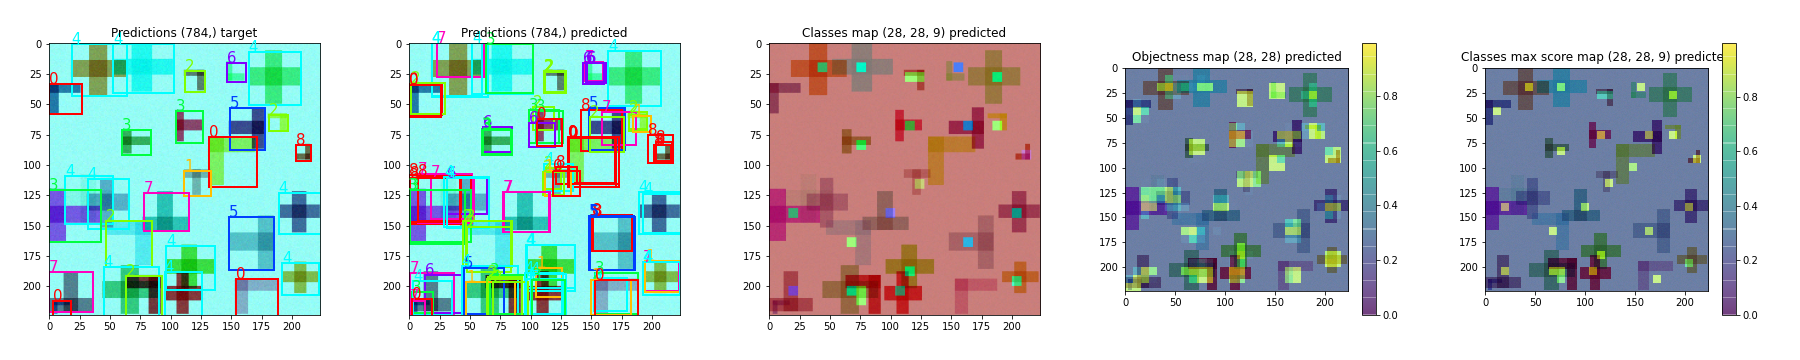

In [36]:
# features, labels = next(iter(prepared_train_dataset))
draw_predictions(quantized_model, features, labels)

In [37]:
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 16s 165ms/step - loss: 0.1076 - fm28x28/objectness_loss: 0.0134 - fm28x28/box_shape_loss: 0.0066 - fm28x28/classes_loss: 0.0097 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2280 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9980 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9774 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0596 - fm28x28/classes_MulticlassAccuracyMetric: 0.9890


[0.10762371122837067,
 0.01344248652458191,
 0.006574190687388182,
 0.00968796294182539,
 0.2280481904745102,
 0.9980103969573975,
 0.9773710370063782,
 0.05959782004356384,
 0.9890011548995972]

In [38]:
# creates one TFLite version of the model:  
#  - models/quantized-model.tflite

exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 64, # representative dataset number of samples, used when convert_quantized_model is True
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # full integer quantization  does not work with QAT models
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_1/Identity:0", shape=(1, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_1/Identity:0", shape=(1, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_1/Identity:0", shape=(1, 784, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                

100%|██████████| 16/16 [00:01<00:00,  8.46it/s]

INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001483 
	RMSE    =  0.007538 
	Keras   = N(μ=  0.071378, σ=  0.231848)
	tflite  = N(μ=  0.071148, σ=  0.231853)
 - export/box_shape/output   
	MAE     =  0.001198 
	RMSE    =  0.001954 
	Keras   = N(μ=  0.313887, σ=  0.277655)
	tflite  = N(μ=  0.313773, σ=  0.277664)
 - export/classes/output     
	MAE     =  0.000059 
	RMSE    =  0.001456 
	Keras   = N(μ=  0.002280, σ=  0.043190)
	tflite  = N(μ=  0.002278, σ=  0.043215)


# Benchmark models

In [0]:
import keras_detection.evaluation.detection_metrics as det_metrics
from keras_detection.ops.python_ops import map_nested_dict
from pathlib import Path

In [0]:
all_tflite_paths = [
  ('Keras', False ,'models/non-quantized-model.h5'), # Keras model
  ('Keras => TFLite', False ,'models/non-quantized-model.tflite'), # from Keras model
  ('Keras => TFLite (Post Quantized)', False ,'models/non-quantized-model.quantized.tflite'), # full post train quantization from Keras model
  ('Keras QAT => TFLite', False ,'models/quantized-model.tflite'), # from QAT model
  ('Keras QAT', True ,'models/quantized-model.h5') # a keras model 
]

In [41]:
name, is_quantized, path = all_tflite_paths[0]
box_detector = builder.as_box_detector(path, is_quantized=is_quantized, iou_threshold=0.5)

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_2/Identity:0", shape=(None, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_2/Identity:0", shape=(None, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_2/Identity:0", shape=(None, 784, 9), dtype=float32)


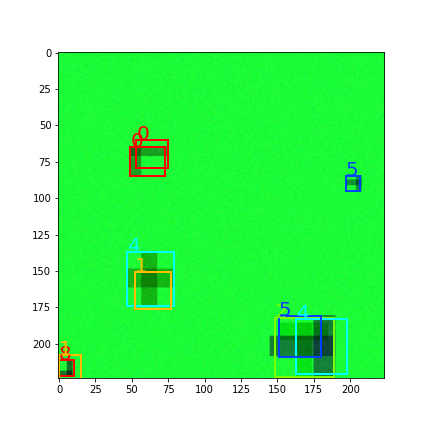

In [42]:
# Test on single prediction
train_dataset_iterator = iter(train_dataset)
batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
idx = 0
image_data = ImageData.from_dict(batch_data)
predictions = box_detector.predict(image_data.features.image)
predictions[idx].draw(image=image_data.features.image[idx], fontsize=20)

## Collecting metrics for few batches

In [43]:
from collections import defaultdict

def benchmark_models(
    models_paths,
    num_batches_to_test = 1,
    iou_threshold = 0.5, # used for compuing metrics
):

  test_models = {
    name: builder.as_box_detector(path, is_quantized=is_quant, iou_threshold=0.5) 
    for name, is_quant, path in models_paths
  }

  test_models_metrics = defaultdict(list)

  print(f"Test models: {test_models.keys()}")

  for i in range(num_batches_to_test):
    print("Testing batch: ", i)
    batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
    image_data = ImageData.from_dict(batch_data)

    for k, predictor in test_models.items():
      print(f" => Predicting: {k}")
      predictions_per_image = predictor.predict(image_data.features.image)
      targets_per_image = image_data.labels.unbatch()
      
      metrics = []
      for target, predicted in zip(targets_per_image, predictions_per_image):
        metrics += det_metrics.image_precision_recall_metrics(
            target=target.replace(weights=None), predicted=predicted.to_labels_frame(), 
            iou_threshold=iou_threshold
        )
      test_models_metrics[k] += metrics
  return test_models_metrics


benchmark_metrics = benchmark_models(all_tflite_paths, num_batches_to_test=5)

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_3/Identity:0", shape=(None, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_3/Identity:0", shape=(None, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_3/Identity:0", shape=(None, 784, 9), dtype=float32)
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorfl

In [44]:
import pandas as pd
data = defaultdict(list)
for model_name, metrics in benchmark_metrics.items():
  for m in det_metrics.aggregate_metrics(metrics):
    data[m.name].append(m.value)
  data["model"].append(model_name)

pd.DataFrame(data).set_index("model")

,localization@0.5/precision,localization@0.5/recall,localization@0.5/f1_score,detection@0.5/precision,detection@0.5/recall,detection@0.5/f1_score
model,,,,,,
Keras,0.677235,0.987203,0.799887,0.645900,0.941499,0.762854
Keras => TFLite,0.676951,0.985375,0.799387,0.647170,0.941499,0.764012
Keras => TFLite (Post Quantized),0.674114,0.989031,0.799242,0.623636,0.914077,0.739094
Keras QAT => TFLite,0.709866,0.983547,0.820710,0.680432,0.941499,0.786209
Keras QAT,0.708910,0.985375,0.820176,0.678706,0.941499,0.784583


# Train Quantized model for short time

In [45]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5" # initialize weight from previous model
)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Running quantization for model backbone: model
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)


In [46]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=1, steps_per_epoch=100)

optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=1, steps_per_epoch=100)

quantized_model.save_weights("models/quantized-model-short-train.h5")

100/100 [==============================] - 18s 183ms/step - loss: 0.1133 - fm28x28/objectness_loss: 0.0151 - fm28x28/box_shape_loss: 0.0087 - fm28x28/classes_loss: 0.0112 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2307 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9966 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9719 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0586 - fm28x28/classes_MulticlassAccuracyMetric: 0.9850


In [47]:
exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model-short-train.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 64, # representative dataset number of samples, used when convert_quantized_model is True
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # full integer quantization  does not work with QAT models
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_5/Identity:0", shape=(1, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_5/Identity:0", shape=(1, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_5/Identity:0", shape=(1, 784, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                

100%|██████████| 16/16 [00:01<00:00,  8.28it/s]

INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001024 
	RMSE    =  0.005529 
	Keras   = N(μ=  0.072649, σ=  0.234176)
	tflite  = N(μ=  0.072331, σ=  0.233616)
 - export/box_shape/output   
	MAE     =  0.000758 
	RMSE    =  0.001167 
	Keras   = N(μ=  0.307383, σ=  0.280005)
	tflite  = N(μ=  0.307304, σ=  0.280046)
 - export/classes/output     
	MAE     =  0.000036 
	RMSE    =  0.000915 
	Keras   = N(μ=  0.002350, σ=  0.044299)
	tflite  = N(μ=  0.002349, σ=  0.044281)


# Benchmark model

In [50]:
all_tflite_paths_with_short = all_tflite_paths + [
  ('Keras QAT => TFLite (short)', False ,'models/quantized-model-short-train.tflite'),
  ('Keras QAT (short)', True ,'models/quantized-model-short-train.h5')
]
benchmark_metrics = benchmark_models(all_tflite_paths_with_short, num_batches_to_test=5)

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f04f6d7fa58>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_9/Identity:0", shape=(None, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_9/Identity:0", shape=(None, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_9/Identity:0", shape=(None, 784, 9), dtype=float32)
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorfl

In [51]:
data = defaultdict(list)
for model_name, metrics in benchmark_metrics.items():
  for m in det_metrics.aggregate_metrics(metrics):
    data[m.name].append(m.value)
  data["model"].append(model_name)

pd.DataFrame(data).set_index("model")

,localization@0.5/precision,localization@0.5/recall,localization@0.5/f1_score,detection@0.5/precision,detection@0.5/recall,detection@0.5/f1_score
model,,,,,,
Keras,0.667256,0.982634,0.792304,0.643282,0.946816,0.763670
Keras => TFLite,0.663857,0.982272,0.789748,0.640753,0.947902,0.762217
Keras => TFLite (Post Quantized),0.669416,0.980825,0.793164,0.628103,0.920767,0.744352
Keras QAT => TFLite,0.676286,0.982996,0.798590,0.649862,0.943922,0.767150
Keras QAT,0.669987,0.983719,0.794291,0.640703,0.939580,0.759190
Keras QAT => TFLite (short),0.700515,0.979016,0.814317,0.673901,0.941027,0.783127
Keras QAT (short),0.700386,0.979740,0.814361,0.674020,0.942113,0.783471
